In [95]:
deps <- c("ISLR", "ndjson", "ggplot2", "dplyr", "caret", "tidyr", "gridExtra", "data.table", "repr", "reshape2", "grid")
for (p in deps) {
    if (!requireNamespace(p, quietly = TRUE)) {
        install.packages(p, repos = "https://cran.rstudio.com")
    }
    library(p, character.only = TRUE)
}
options(scipen=999)

df <- ndjson::stream_in("./self_ensemble.jsonl")
# print(names(df))

df <- df %>%
    filter(dataset == "cifar10") # cifar10, cifar100, imagenette

# plain

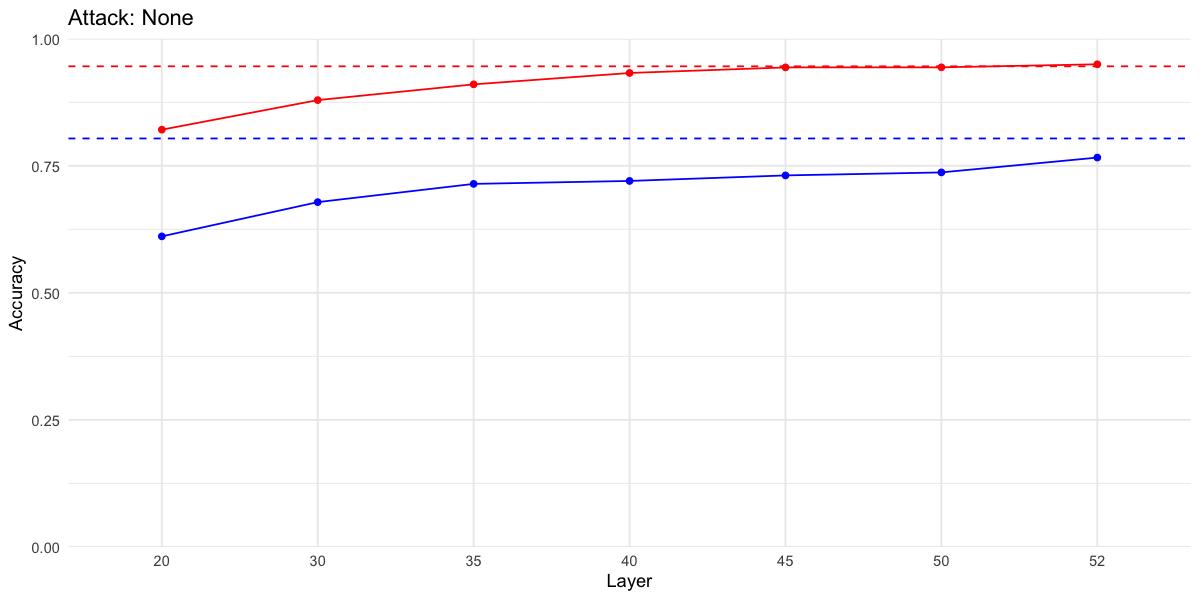

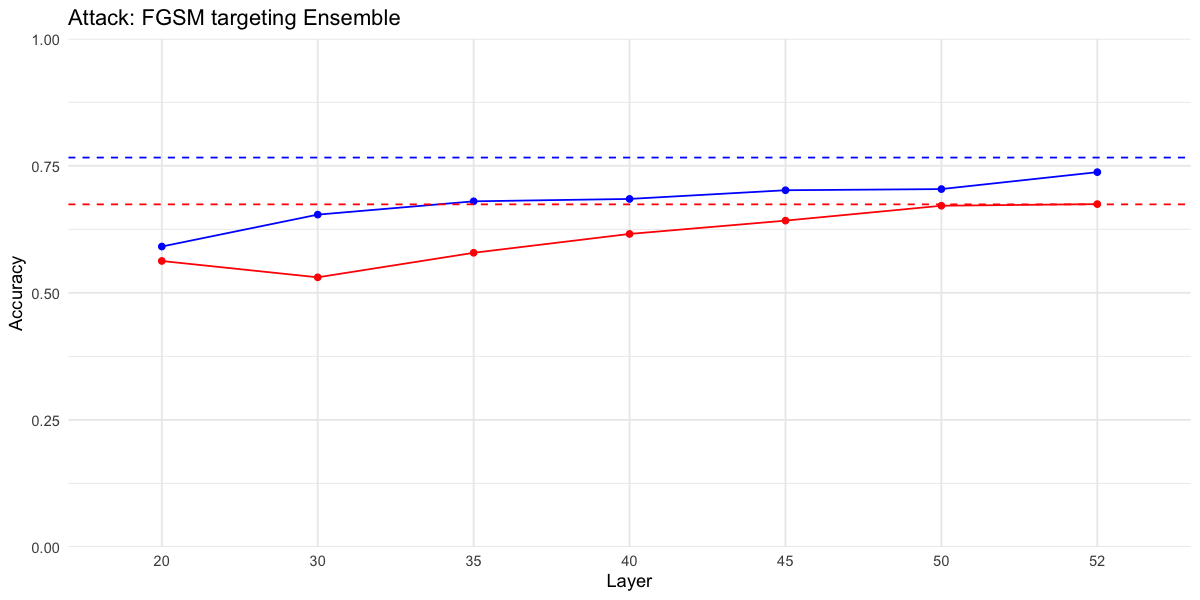

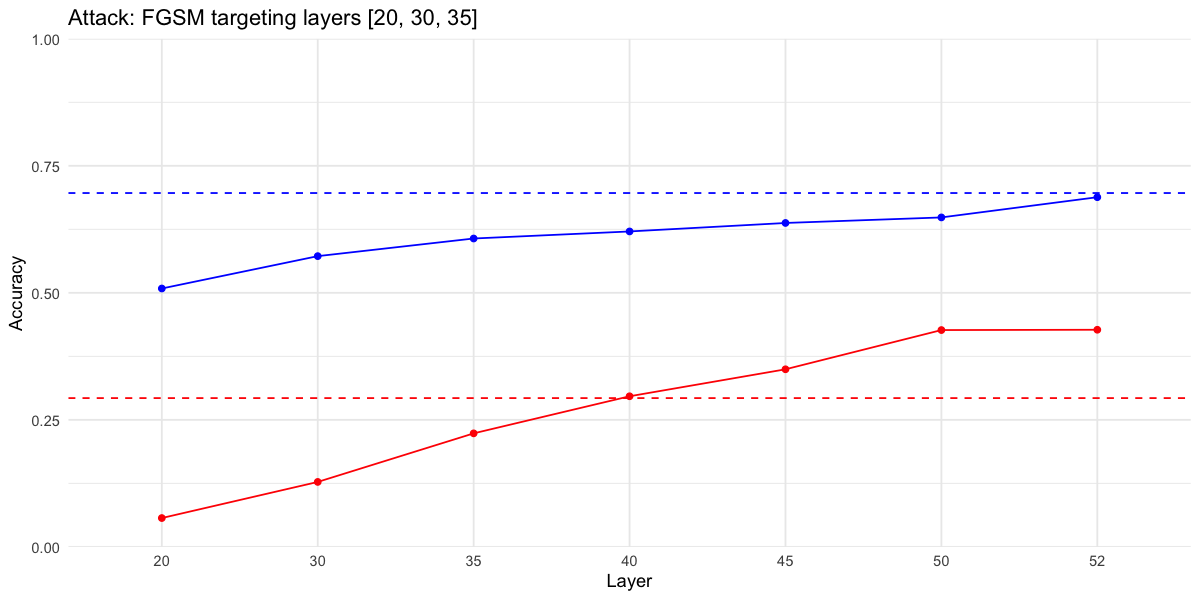

In [106]:
options(repr.plot.width=10, repr.plot.height=5)


plots <- list()

description <- "Attack: None"
acc_cols <- c("plain_layer_accs.20", "plain_layer_accs.30", "plain_layer_accs.35", "plain_layer_accs.40", "plain_layer_accs.45", "plain_layer_accs.50", "plain_layer_accs.52")
acc_ensemble <- "plain_ensemble_acc"
p <- ggplot() +
    # nat
    geom_line(data = melt(df[df$training_natural == TRUE], measure.vars = acc_cols), aes(x = variable, y = value, group = 1), color = "blue") +
    geom_point(data = melt(df[df$training_natural == TRUE], measure.vars = acc_cols), aes(x = variable, y = value), color = "blue") +
    geom_hline(yintercept = df[[acc_ensemble]][2], color = "blue", linetype = "dashed", linewidth = 0.5) +
    # non-nat
    geom_line(data = melt(df[df$training_natural == FALSE], measure.vars = acc_cols), aes(x = variable, y = value, group = 1), color = "red") +
    geom_point(data = melt(df[df$training_natural == FALSE], measure.vars = acc_cols), aes(x = variable, y = value), color = "red") +    
    geom_hline(yintercept = df[[acc_ensemble]][1], color = "red", linetype = "dashed", linewidth = 0.5) +
    ggtitle(description) +
    xlab("Layer") +
    ylab("Accuracy") +
    theme_minimal() +
    scale_y_continuous(expand = c(0, 0), limits = c(0, 1)) + # limit y range
    scale_x_discrete(labels = function(x) sub(".*\\.", "", x)) # show only layer number on x-axis

print(p)

description <- "Attack: FGSM targeting Ensemble"
acc_cols <- c("fgsmensemble_layer_accs.20", "fgsmensemble_layer_accs.30", "fgsmensemble_layer_accs.35", "fgsmensemble_layer_accs.40", "fgsmensemble_layer_accs.45", "fgsmensemble_layer_accs.50", "fgsmensemble_layer_accs.52")
acc_ensemble <- "fgsmensemble_ensemble_acc"
p <- ggplot() +
    # nat
    geom_line(data = melt(df[df$training_natural == TRUE], measure.vars = acc_cols), aes(x = variable, y = value, group = 1), color = "blue") +
    geom_point(data = melt(df[df$training_natural == TRUE], measure.vars = acc_cols), aes(x = variable, y = value), color = "blue") +
    geom_hline(yintercept = df[[acc_ensemble]][2], color = "blue", linetype = "dashed", linewidth = 0.5) +
    # non-nat
    geom_line(data = melt(df[df$training_natural == FALSE], measure.vars = acc_cols), aes(x = variable, y = value, group = 1), color = "red") +
    geom_point(data = melt(df[df$training_natural == FALSE], measure.vars = acc_cols), aes(x = variable, y = value), color = "red") +    
    geom_hline(yintercept = df[[acc_ensemble]][1], color = "red", linetype = "dashed", linewidth = 0.5) +
    ggtitle(description) +
    xlab("Layer") +
    ylab("Accuracy") +
    theme_minimal() +
    scale_y_continuous(expand = c(0, 0), limits = c(0, 1)) + # limit y range
    scale_x_discrete(labels = function(x) sub(".*\\.", "", x)) # show only layer number on x-axis

print(p)

description <- "Attack: FGSM targeting layers [20, 30, 35]"
acc_cols <- c("fgsmcombined_[20, 30, 35]_layer_accs.20", "fgsmcombined_[20, 30, 35]_layer_accs.30", "fgsmcombined_[20, 30, 35]_layer_accs.35", "fgsmcombined_[20, 30, 35]_layer_accs.40", "fgsmcombined_[20, 30, 35]_layer_accs.45", "fgsmcombined_[20, 30, 35]_layer_accs.50", "fgsmcombined_[20, 30, 35]_layer_accs.52")
acc_ensemble <- "fgsmcombined_[20, 30, 35]_ensemble_acc"
p <- ggplot() +
    # nat
    geom_line(data = melt(df[df$training_natural == TRUE], measure.vars = acc_cols), aes(x = variable, y = value, group = 1), color = "blue") +
    geom_point(data = melt(df[df$training_natural == TRUE], measure.vars = acc_cols), aes(x = variable, y = value), color = "blue") +
    geom_hline(yintercept = df[[acc_ensemble]][2], color = "blue", linetype = "dashed", linewidth = 0.5) +
    # non-nat
    geom_line(data = melt(df[df$training_natural == FALSE], measure.vars = acc_cols), aes(x = variable, y = value, group = 1), color = "red") +
    geom_point(data = melt(df[df$training_natural == FALSE], measure.vars = acc_cols), aes(x = variable, y = value), color = "red") +    
    geom_hline(yintercept = df[[acc_ensemble]][1], color = "red", linetype = "dashed", linewidth = 0.5) +
    ggtitle(description) +
    xlab("Layer") +
    ylab("Accuracy") +
    theme_minimal() +
    scale_y_continuous(expand = c(0, 0), limits = c(0, 1)) + # limit y range
    scale_x_discrete(labels = function(x) sub(".*\\.", "", x)) # show only layer number on x-axis

print(p)



# grid.arrange(
#     grobs = plots, 
#     ncol = 2, 
#     top = textGrob(paste("No Perturbations\nDataset:", ds), gp = gpar(fontsize = 30, fontface = "bold"))
# )


# latent shift

we want to show how much classes have been "moved" by the attack

- get 100 samples from each class
- for all layers: forward to layer, then dump latents instead of linear probe -> stack latents for all images
- repeat also with perturbed images (masks)

plot:

- make tsne / umap plot
- only fit to unperturbed images, not to perturbed images: https://umap-learn.readthedocs.io/en/latest/transform.html
- use color/shape to encode whether they're perturbed/unperturbed and the class
